In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import warnings
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize
import plotly.express as px
from plotly.offline import init_notebook_mode

warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [2]:
path = "../data/train/*/*.jpg"
images = glob(path)
len(images)

2637

In [4]:
df = pd.DataFrame({"filepath": images})
df["label"] = df["filepath"].str.split("/", expand=True)[3]

In [7]:
df["label"].value_counts()

benign       1440
malignant    1197
Name: label, dtype: int64

In [9]:
labels = df["label"].value_counts()

values = labels.values
names = labels.index

fig = px.pie(df, values=values, names=names, hole=0.5)
fig.show()

In [20]:
X = df["filepath"]
y = df["label"]

In [22]:
def decode_image(filepath, label=None):
    image = read_file(filepath)
    image = decode_jpeg(image)
    image = resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    
    if label == "benign":
        Label = 0
    else:
        Label = 1
        
    return image, Label

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)

In [26]:
AUTO = tf.data.experimental.AUTOTUNE

In [28]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [29]:
test_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [31]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [32]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10


2023-05-28 22:48:06.644813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2109]
	 [[{{node Placeholder/_1}}]]
2023-05-28 22:48:06.645799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2109]
	 [[{{node Placeholder/_1}}]]


66/66 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.6752

2023-05-28 22:48:56.212071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2109]
	 [[{{node Placeholder/_1}}]]
2023-05-28 22:48:56.212441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2109]
	 [[{{node Placeholder/_1}}]]


66/66 [==============================] - 66s 993ms/step - loss: 0.6265 - accuracy: 0.6752 - val_loss: 0.5155 - val_accuracy: 0.7572
Epoch 2/10
66/66 [==============================] - 77s 1s/step - loss: 0.4623 - accuracy: 0.7667 - val_loss: 0.4116 - val_accuracy: 0.7994
Epoch 3/10
66/66 [==============================] - 73s 1s/step - loss: 0.4202 - accuracy: 0.7866 - val_loss: 0.3631 - val_accuracy: 0.8127
Epoch 4/10
66/66 [==============================] - 72s 1s/step - loss: 0.3824 - accuracy: 0.7975 - val_loss: 0.3392 - val_accuracy: 0.8260
Epoch 5/10
66/66 [==============================] - 68s 1s/step - loss: 0.3483 - accuracy: 0.8255 - val_loss: 0.3144 - val_accuracy: 0.8393
Epoch 6/10
66/66 [==============================] - 71s 1s/step - loss: 0.3261 - accuracy: 0.8288 - val_loss: 0.3004 - val_accuracy: 0.8511
Epoch 7/10
66/66 [==============================] - 72s 1s/step - loss: 0.3344 - accuracy: 0.8269 - val_loss: 0.2773 - val_accuracy: 0.8630
Epoch 8/10
66/66 [==========

In [33]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.626508,0.675202,0.515491,0.757231
1,0.462346,0.766714,0.411628,0.799431
2,0.420226,0.786629,0.363105,0.812707
3,0.382448,0.797534,0.339240,0.825984
4,0.348298,0.825510,0.314413,0.839260


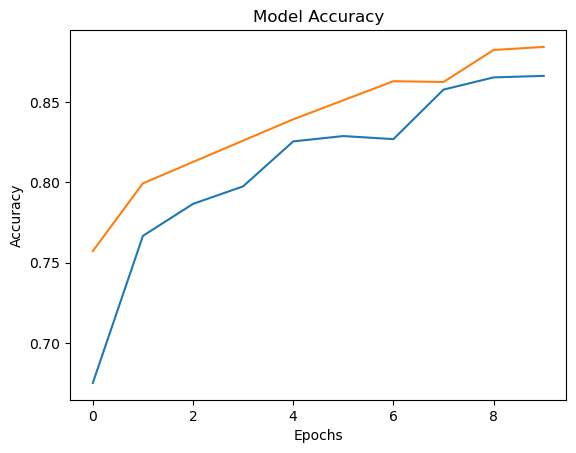

In [35]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.show()

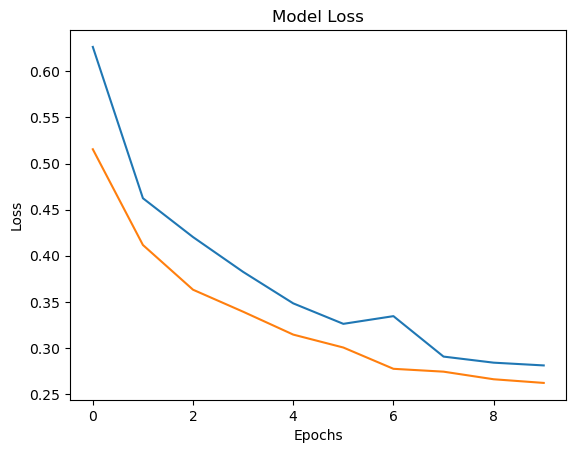

In [36]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.show()

In [37]:
model.save("skin.h5")